In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

2025-06-06 22:53:10.458639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749250390.661987      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749250390.721075      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
base_dir = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'
categories = os.listdir(base_dir)
num_classes = len(categories)
print(f"Total Classes: {num_classes}")

Total Classes: 90


In [ ]:
image_paths, labels = [], []

for category in tqdm(os.listdir(base_dir)):
    for img_filepath in os.listdir(os.path.join(base_dir,category)):
        image_path = os.path.join(base_dir,category,img_filepath)
        image_paths.append(image_path)
        labels.append(category)

len(image_paths), len(labels)

  0%|          | 0/90 [00:00<?, ?it/s]

(5400, 5400)

In [ ]:
df = pd.DataFrame({'image_filepath': image_paths, 'label': labels})
df.head()

,image_filepath,label
0,/kaggle/input/animal-image-dataset-90-differen...,beetle
1,/kaggle/input/animal-image-dataset-90-differen...,beetle
2,/kaggle/input/animal-image-dataset-90-differen...,beetle
3,/kaggle/input/animal-image-dataset-90-differen...,beetle
4,/kaggle/input/animal-image-dataset-90-differen...,beetle


In [ ]:

label_idx_mapping = dict()

for idx, label in enumerate(encoder.classes_):
    label_idx_mapping[label] = idx

label_idx_mapping

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

In [ ]:
train_df, temp_df = train_test_split(df,train_size=0.7,stratify=df['label'],random_state=101)
val_df, test_df = train_test_split(temp_df,train_size=0.7,stratify=temp_df['label'],random_state=101)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((3779, 3), (1134, 3), (487, 3))

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
generator

In [ ]:
train_data_generator = generator.flow_from_dataframe(
    train_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 3779 validated image filenames belonging to 90 classes.


In [ ]:
val_data_generator = generator.flow_from_dataframe(
    val_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 1134 validated image filenames belonging to 90 classes.


In [ ]:
test_data_generator = generator.flow_from_dataframe(
    test_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 487 validated image filenames belonging to 90 classes.


In [ ]:
n_classes = len(train_data_generator.class_indices)
n_classes

90

In [ ]:

efficient_net_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='max'
)

I0000 00:00:1749250419.111879      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

for layer in efficient_net_model.layers:
    layer.trainable = False

In [ ]:

augment_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
],name='augmentation_layer')

In [ ]:
inputs = Input(shape=(224,224,3))
x = augment_layer(inputs)
x = efficient_net_model(x, training=False)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(units=n_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,401,661 (16.79 MB)

 Trainable params: 351,578 (1.34 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=5e-4),
             metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,restore_best_weights=True,start_from_epoch=5),
    ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,patience=2,verbose=1),
    TensorBoard(log_dir='./',histogram_freq=1,write_graph=True,update_freq='epoch',embeddings_freq=1),
    ModelCheckpoint(filepath='animal_image_classifier.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1,save_freq='epoch')
]

r = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=len(train_data_generator),
    validation_steps=len(val_data_generator),
    verbose=1
)

Epoch 1/50


E0000 00:00:1749250440.889028      18 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749250443.713341      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.1340 - loss: 4.2645
Epoch 1: val_accuracy improved from -inf to 0.66402, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 522ms/step - accuracy: 0.1351 - loss: 4.2571 - val_accuracy: 0.6640 - val_loss: 1.4873 - learning_rate: 5.0000e-04
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5786 - loss: 1.8808
Epoch 2: val_accuracy improved from 0.66402 to 0.77160, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 272ms/step - accuracy: 0.5789 - loss: 1.8795 - val_accuracy: 0.7716 - val_loss: 0.9108 - learning_rate: 5.0000e-04
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7125 - loss: 1.2901
Epoch 3: val_accuracy improved from 0.77160 to 0.82363, saving model to animal_image_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 270ms/step - accuracy: 0.7125 - loss: 1.2896 - val_accuracy: 0.8236 - val_loss: 0.7448 - learning_rate: 5.0000e-04


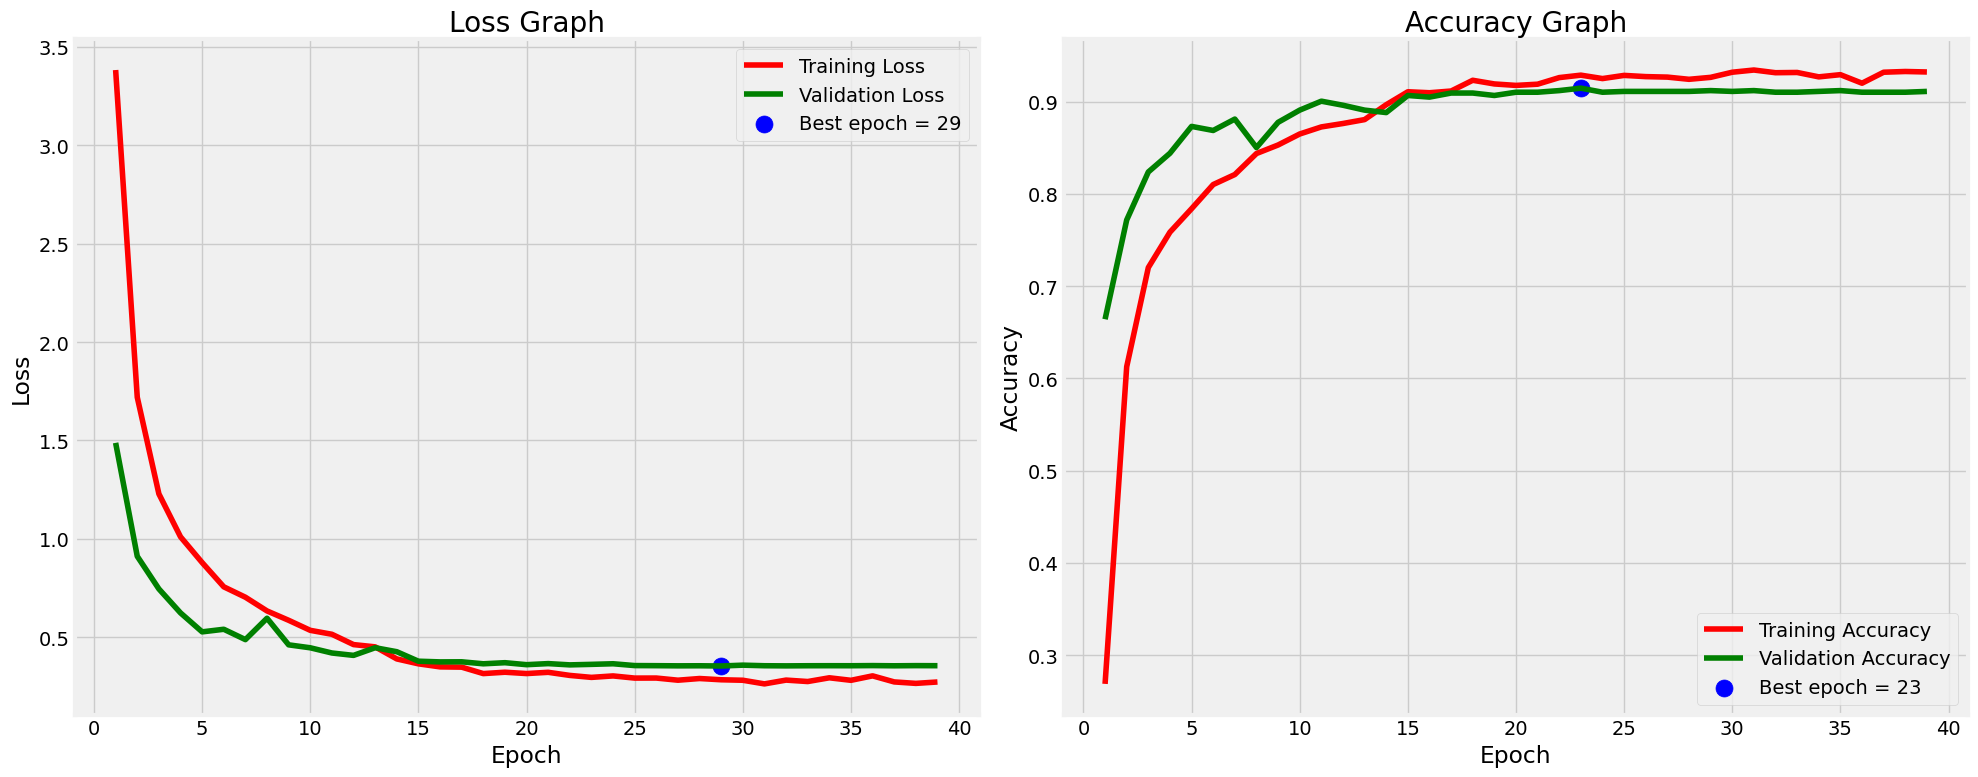

In [ ]:

train_acc = r.history['accuracy']
train_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

epochs = list(range(1, len(train_acc) + 1))
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'


plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

In [ ]:
saved_model = model

In [ ]:

for layer in efficient_net_model.layers:
    layer.trainable = True

for layer in efficient_net_model.layers[-30:]:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

In [ ]:
for layer in efficient_net_model.layers:
    if isinstance(layer, BatchNormalization):
        print(f"{layer.name} — trainable: {layer.trainable}")

stem_bn — trainable: True
block1a_bn — trainable: True
block1a_project_bn — trainable: True
block2a_expand_bn — trainable: True
block2a_bn — trainable: True
block2a_project_bn — trainable: True
block2b_expand_bn — trainable: True
block2b_bn — trainable: True
block2b_project_bn — trainable: True
block3a_expand_bn — trainable: True
block3a_bn — trainable: True
block3a_project_bn — trainable: True
block3b_expand_bn — trainable: True
block3b_bn — trainable: True
block3b_project_bn — trainable: True
block4a_expand_bn — trainable: True
block4a_bn — trainable: True
block4a_project_bn — trainable: True
block4b_expand_bn — trainable: True
block4b_bn — trainable: True
block4b_project_bn — trainable: True
block4c_expand_bn — trainable: True
block4c_bn — trainable: True
block4c_project_bn — trainable: True
block5a_expand_bn — trainable: True
block5a_bn — trainable: True
block5a_project_bn — trainable: True
block5b_expand_bn — trainable: True
block5b_bn — trainable: True
block5b_project_bn — traina

In [ ]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-5,
    first_decay_steps=10,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
             optimizer=Adam(learning_rate=lr_schedule),
             metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,401,661 (16.79 MB)

 Trainable params: 4,348,630 (16.59 MB)

 Non-trainable params: 53,031 (207.16 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1,restore_best_weights=True,start_from_epoch=5),
    TensorBoard(log_dir='./',histogram_freq=1,write_graph=True,update_freq='epoch',embeddings_freq=1),
    ModelCheckpoint(filepath='fine_tuned_animal_classifier.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1,save_freq='epoch')
]

r_fine = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=len(train_data_generator),
    validation_steps=len(val_data_generator),
    verbose=1
)

Epoch 1/50


E0000 00:00:1749251751.045180      18 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7734 - loss: 1.7596
Epoch 1: val_accuracy improved from -inf to 0.86684, saving model to fine_tuned_animal_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 392ms/step - accuracy: 0.7734 - loss: 1.7596 - val_accuracy: 0.8668 - val_loss: 1.5789
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7948 - loss: 1.6940
Epoch 2: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.7947 - loss: 1.6942 - val_accuracy: 0.8148 - val_loss: 1.6741
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8004 - loss: 1.6601
Epoch 3: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - accuracy: 0.8003 - loss: 1.6604 - val_accuracy: 0.7919 - val_loss: 1.7213
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8001 - loss: 1.6782
Epoch 4: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 338ms/st

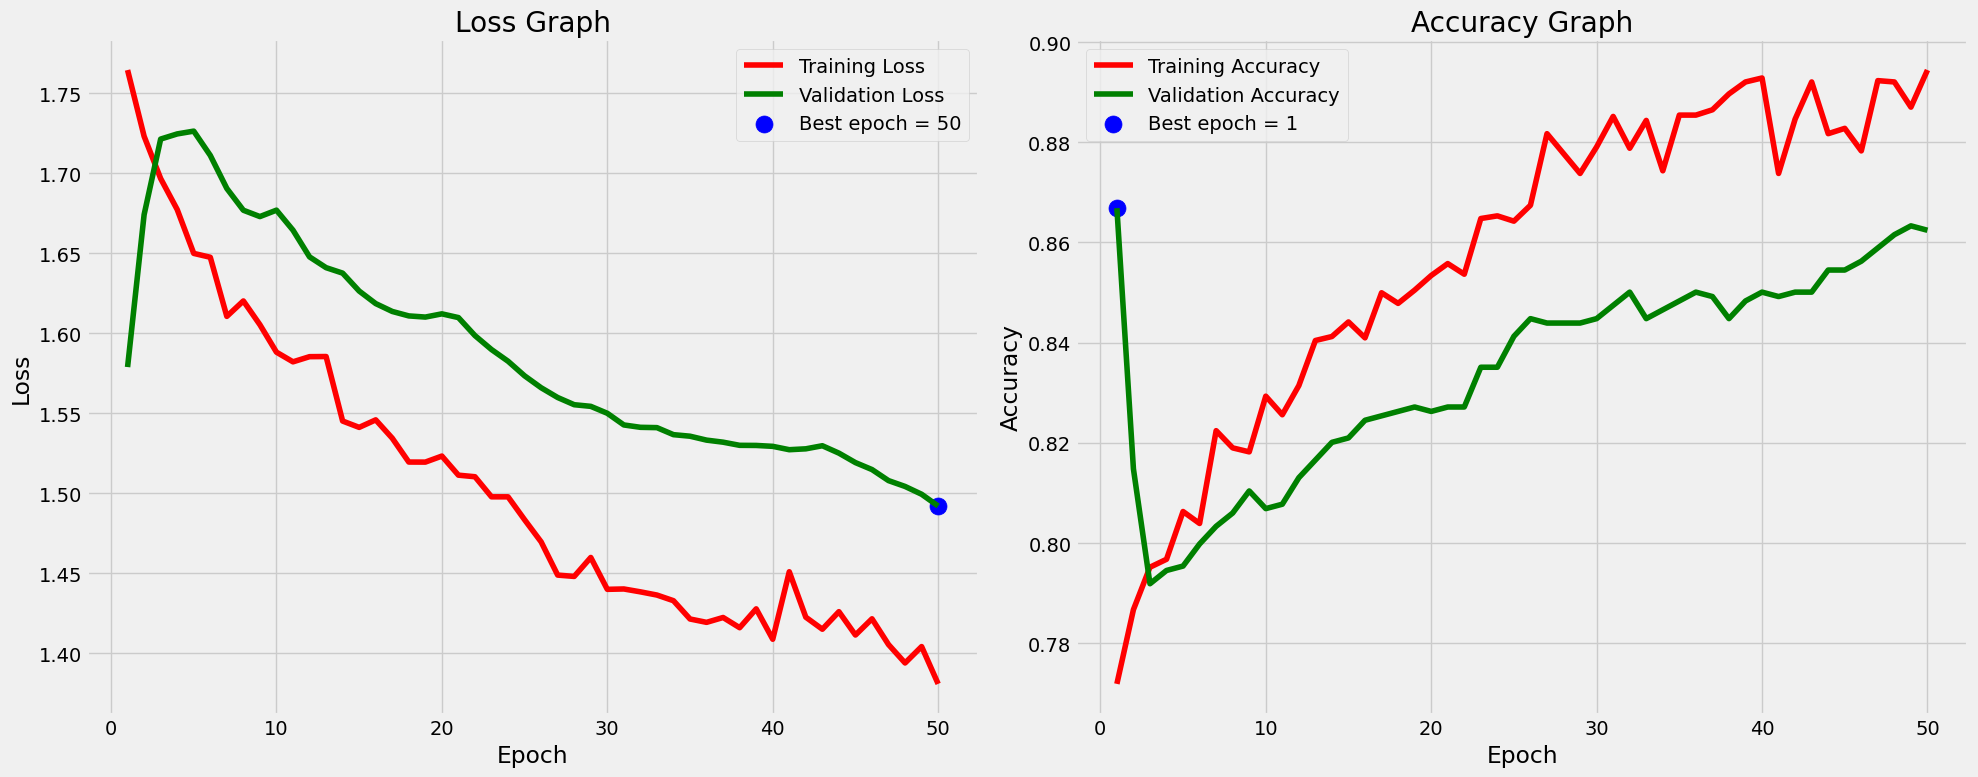

In [ ]:
 train_acc = r_fine.history['accuracy']
train_loss = r_fine.history['loss']
val_acc = r_fine.history['val_accuracy']
val_loss = r_fine.history['val_loss']


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]


epochs = list(range(1, len(train_acc) + 1))
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'


plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

In [ ]:
best_model = load_model('animal_image_classifier.keras')
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,104,819 (19.47 MB)

 Trainable params: 351,578 (1.34 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

 Optimizer params: 703,158 (2.68 MB)